<a href="https://colab.research.google.com/github/budvinchathura/kvasir/blob/master/vgg16_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# ! wget 'https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip'
# ! wget -P 'drive/My Drive/kvasir_project/' 'https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip'

# ! unzip 'kvasir-dataset-v2.zip'
# ! unzip 'drive/My Drive/kvasir_project/kvasir-dataset-v2.zip'
# ! cp -R 'kvasir-dataset-v2' 'drive/My Drive/kvasir_project'

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

# ! unzip 'drive/My Drive/DatasetZip/test-Set.zip' -d "./"
# ! unzip 'drive/My Drive/DatasetZip/train-Set.zip' -d "./"
# ! mkdir "checkpoint"


In [1]:
HEIGHT = 150
WIDTH = 150

# from keras.applications.resnet50 import ResNet50, preprocess_input
# base_model = ResNet50(weights='imagenet', 
#                       include_top=False, 
#                       input_shape=(HEIGHT, WIDTH, 3))


from keras.applications.vgg16 import VGG16, preprocess_input
base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))


# from keras.applications.inception_v3 import InceptionV3, preprocess_input
# base_model = InceptionV3(weights='imagenet', 
#                       include_top=False, 
#                       input_shape=(HEIGHT, WIDTH, 3))


# from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
# base_model = ResNet50V2(weights='imagenet', 
#                       include_top=False, 
#                       input_shape=(HEIGHT, WIDTH, 3))


Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "train-Set"
TEST_DIR = "test-Set"
HEIGHT = 150
WIDTH = 150
BATCH_SIZE = 32

# train_datagen =  ImageDataGenerator(
#       preprocessing_function=preprocess_input,
#       rotation_range=90,
#       horizontal_flip=True,
#       vertical_flip=True
#     )

# train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
#                                                     target_size=(HEIGHT, WIDTH), 
#                                                     batch_size=BATCH_SIZE)




train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)





Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


In [3]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["dyed-lifted-polyps", "dyed-resection-margins", "esophagitis","normal-cecum","normal-pylorus","normal-z-line","polyps","ulcerative-colitis"]
FC_LAYERS = [64,1024,64]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 70
BATCH_SIZE = 32
num_train_images = 6400
num_test_images = 1600

adam = Adam(lr=0.0001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

print(finetune_model.summary())





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/70
200/200 [==============================] - 118s 590ms/step - loss: 3.1334 - acc: 0.1338 - val_loss: 2.0247 - val_acc: 0.2263
Epoch 2/70
200/200 [==============================] - 111s 557ms/step - loss: 2.0609 - acc: 0.1514 - val_loss: 1.9507 - val_acc: 0.2450
Epoch 3/70
200/200 [==============================] - 112s 559ms/step - loss: 1.9955 - acc: 0.1909 - val_loss: 1.8629 - val_acc: 0.3075
Epoch 4/70
200/200 [==============================] - 111s 555ms/step - loss: 1.9090 - acc: 0.2417 - val_loss: 1.5935 - val_acc: 0.4313
Epoch 5/70
200/200 [==============================] - 110s 552ms/step - loss: 1.7333 - acc: 0.3169 - val_loss: 1.2796 - val_acc: 0.5613
Epoch 6/70
200/200 [==============================] - 110s 549ms/step - loss: 1.6216 - acc: 0.3769 - val_loss: 1.1867 - val_acc: 0.5856
Epoch 7/70
200/200 [==============================] - 110s 549ms/step - loss: 1.5141 - a

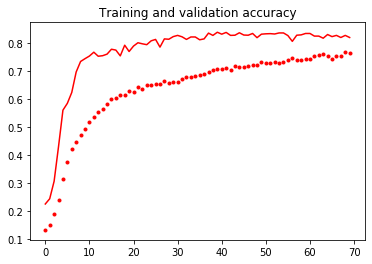

<Figure size 432x288 with 0 Axes>

In [5]:
history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True,validation_data=test_generator,validation_steps=num_test_images//BATCH_SIZE)



# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')

plot_training(history)
